In [16]:
import warnings
warnings.filterwarnings("ignore")

import sys,os

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

import glob
import xarray as xr
import datetime

# import yaml
import tqdm
import time
import torch
import torchvision
import h5py

import pickle
import joblib
import logging
import random

from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple
# from multiprocessing import cpu_count

import torch.fft
from torch import nn

import torch.nn.functional as F

# from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.models as models
from torch.optim.lr_scheduler import *

from sklearn.model_selection import train_test_split

from collections import defaultdict
import pandas as pd

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    #torch.backends.cudnn.deterministic = True

In [3]:
def torch_holo_set(Ein: torch.tensor,
                   fx: torch.tensor,
                   fy: torch.tensor,
                   z_tnsr: torch.tensor,
                   lam: float):
    """
    Propagates an electric field a distance z
    Ein complex torch.tensor
    - input electric field
    
    fx:real torch.tensor
    - x frequency axis (3D, setup to broadcast)
    
    fy: real torch.tensor
    - y frequency axis (3D, setup to broadcast)
    
    z_tnsr: torch.tensor
    - tensor of distances to propagate the wave Ein
        expected to have dims (Nz,1,1) where Nz is the number of z
        dimensions
    
    lam: float
    - wavelength
    
    returns: complex torch.tensor with dims (Nz,fy,fx)
    
    Note the torch.fft library uses dtype=torch.complex64
    This may be an issue for GPU implementation
    
    """
    Etfft = torch.fft.fft2(Ein)
#     Eofft = Etfft*torch.cos(2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    
    # It might be helpful if we could omit this step.  It would save an inverse fft.
    Eout = torch.fft.ifft2(Eofft)
    
    return Eout

In [4]:
real_path = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/real_holograms_CSET_RF07_20150719_200000-210000.nc"
synthetic_path = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_training.nc"

In [5]:
h_ds = xr.open_dataset(synthetic_path)

### Define the tile size and stride

In [6]:
tile_size = 512  # size of tiled images in pixels
step_size = 128  # amount that we shift the tile to make a new tile
marker_size = 10 # UNET gaussian marker width (standard deviation) in um

# step_size is not allowed be be larger than the tile_size
assert tile_size >= step_size

### Definite z-bin resolution

In [7]:
n_bins = 1000  # number of bins in histogram
z_bins = np.linspace(h_ds.attrs['zMin'],h_ds.attrs['zMax'],n_bins+1)*1e6  # histogram bin edges
z_centers = z_bins[:-1] + 0.5*np.diff(z_bins)  # histogram bin centers

### Load physical information about the hologram

In [8]:
dx = h_ds.attrs['dx']      # horizontal resolution
dy = h_ds.attrs['dy']      # vertical resolution
Nx = int(h_ds.attrs['Nx']) # number of horizontal pixels
Ny = int(h_ds.attrs['Ny']) # number of vertical pixels
lam = h_ds.attrs['lambda'] # wavelength
zMin = h_ds.attrs['zMin']  # minimum z in sample volume
zMax = h_ds.attrs['zMax']  # maximum z in sample volume
zCCD = 0                   # z position of the image plane
num_per_holo = 1
image_norm = 255.0

In [9]:
x_arr = np.arange(-Nx//2,Nx//2)*dx
y_arr = np.arange(-Ny//2,Ny//2)*dy

In [10]:
# create the frequency axes on the "device" needed for the reconstruction calculation
fx = torch.fft.fftfreq(Nx,dx,device=device).unsqueeze(0).unsqueeze(2)
fy = torch.fft.fftfreq(Ny,dy,device=device).unsqueeze(0).unsqueeze(1)

In [11]:
# create histogram bins
tile_x_bins = np.arange(-Nx//2, Nx//2, step_size)*dx*1e6
tile_y_bins = np.arange(-Ny//2, Ny//2, step_size)*dy*1e6

In [12]:
def get_reconstructed_sub_images(h_idx, h_ds, part_per_holo, empt_per_holo):
    """
    Reconstruct a hologram at specific planes to provide training data
    with a specified number of sub images containing and not containing
    particles
    """
    
    # locate particle information corresponding to this hologram
    particle_idx = np.where(h_ds['hid'].values==h_idx+1)
    
    x_part = h_ds['x'].values[particle_idx]
    y_part = h_ds['y'].values[particle_idx]
    z_part = h_ds['z'].values[particle_idx]
    d_part = h_ds['d'].values[particle_idx]  # not used but here it is
    
    # create a 3D histogram 
    in_data = np.stack((x_part,y_part,z_part)).T
    h_part = np.histogramdd(in_data,bins=[tile_x_bins,tile_y_bins,z_bins])[0]
    z_part_bin_idx = np.digitize(z_part,z_bins)-1 # specify the z bin locations of the particles
    
    # smoothing kernel accounts for overlapping subimages when the 
    # subimage is larger than the stride
    if step_size < tile_size:
        overlap_kernel = np.ones((tile_size//step_size,tile_size//step_size))
        for z_idx in range(h_part.shape[-1]):
            h_part[:,:,z_idx] = convolve2d(h_part[:,:,z_idx],overlap_kernel)[tile_size//step_size-1:h_part.shape[0]+tile_size//step_size-1,tile_size//step_size-1:h_part.shape[1]+tile_size//step_size-1]
    
    # locate all the cases where particles are and are not present
    # to sample from those cases
    if step_size < tile_size:
        # note that the last bin is ommitted from each to avoid edge cases where
        # the image is not complete

        edge_idx = tile_size//step_size-1

        # find the locations where particles are in focus
        loc_idx = np.where(h_part[:-edge_idx,:-edge_idx,:] > 0)
        # find locations where particles are not in focus
        empt_idx = np.where(h_part[:-edge_idx,:-edge_idx,:] == 0)
    else:
        # find the locations where particles are in focus
        loc_idx = np.where(h_part > 0)
        # find locations where particles are not in focus
        empt_idx = np.where(h_part == 0)
        
    # select sub images with particles in them
    if part_per_holo > loc_idx[0].size:
        # pick the entire set
        loc_x_idx = loc_idx[0]
        loc_y_idx = loc_idx[1]
        loc_z_idx = loc_idx[2]
    else:
        # randomly select particles from the set
        sel_part_idx = np.random.choice(np.arange(loc_idx[0].size,dtype=int), size=part_per_holo, replace=False)
        loc_x_idx = loc_idx[0][sel_part_idx]
        loc_y_idx = loc_idx[1][sel_part_idx]
        loc_z_idx = loc_idx[2][sel_part_idx]

    # randomly select empties from the empty set
    sel_empt_idx = np.random.choice(np.arange(empt_idx[0].size,dtype=int), size=empt_per_holo, replace=False)
    empt_x_idx = empt_idx[0][sel_empt_idx]
    empt_y_idx = empt_idx[1][sel_empt_idx]
    empt_z_idx = empt_idx[2][sel_empt_idx]
    
    # full set of plane indices to reconstruct (empty and with particles)
    z_full_idx = np.unique(np.concatenate((loc_z_idx,empt_z_idx)))
    
    # build the torch tensor for reconstruction
    z_plane = torch.tensor(z_centers[z_full_idx]*1e-6,device=device).unsqueeze(-1).unsqueeze(-1)
    
    # create the torch tensor for propagation
    E_input = torch.tensor(h_ds['image'].isel(hologram_number=h_idx).values).to(device).unsqueeze(0)
    
    # reconstruct the selected planes
    E_out = torch_holo_set(E_input,fx,fy,z_plane,lam).detach().cpu().numpy()
    
    # grab the sub images corresponding to the selected data points
    particle_in_focus_lst = []  # training labels for if particle is in focus
    particle_unet_labels_lst = []  # training labels for if particle is in focus
    image_lst = []  # sliced reconstructed image
    image_index_lst = []  # indices used to identify the image slice
    image_corner_coords = []  # coordinates of the corner of the image slice

    for sub_idx,z_idx in enumerate(z_full_idx):
        part_set_idx = np.where(loc_z_idx == z_idx)[0]
        empt_set_idx = np.where(empt_z_idx == z_idx)[0]
        
        unet_mask = np.zeros(h_ds['image'].shape[1:])  # initialize the UNET mask
        part_in_plane_idx = np.where(z_part_bin_idx==z_idx)[0]  # locate all particles in this plane

        # build the UNET mask for this z plane
        for part_idx in part_in_plane_idx:
            unet_mask += np.exp(-(y_arr[None,:]*1e6-y_part[part_idx])**2/(2*marker_size**2) - (x_arr[:,None]*1e6-x_part[part_idx])**2/(2*marker_size**2) )

        for part_idx in part_set_idx:
            x_idx = loc_x_idx[part_idx]
            y_idx = loc_y_idx[part_idx]
            image_lst.append(E_out[sub_idx,x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])
            image_index_lst.append([x_idx,y_idx,z_idx])
            image_corner_coords.append([x_arr[x_idx*step_size], y_arr[y_idx*step_size]])
            particle_in_focus_lst.append(1)
            particle_unet_labels_lst.append(unet_mask[x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])

        for empt_idx in empt_set_idx:
            x_idx = empt_x_idx[empt_idx]
            y_idx = empt_y_idx[empt_idx]
            image_lst.append(E_out[sub_idx,x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])
            image_index_lst.append([x_idx,y_idx,z_idx])
            image_corner_coords.append([x_arr[x_idx*step_size], y_arr[y_idx*step_size]])
            particle_in_focus_lst.append(0)
            particle_unet_labels_lst.append(unet_mask[x_idx*step_size:(x_idx*step_size+tile_size),y_idx*step_size:(y_idx*step_size+tile_size)])
            
    return particle_in_focus_lst, image_lst, image_index_lst, image_corner_coords, particle_unet_labels_lst

In [13]:
def get_next_hologram(h_ds, part_per_holo, empt_per_holo, max_holograms=None):
    """
    Generator to build a dataset of hologram patches
    h_ds - xarray dataset of the original hologram
    part_per_holo - number of particles with particles to get from each hologram
    empt_per_holo - number of empty patches to grab from each hologram
    max_holograms - the maximum number of holograms to load
    """
    
    number_of_holograms = h_ds.dims['hologram_number']
    if max_holograms is None:
        max_holograms = number_of_holograms
    if max_holograms is 0:
        max_holograms = 1
    
    tot = 0
    stop_early = False
    while True:
        
        # shuffle 
        hologram_numbers = list(range(number_of_holograms))
        random.shuffle(hologram_numbers)

        # loop over the hologram numbers
        for h_idx in hologram_numbers:
            
            #sub_label, sub_image, image_index_lst, image_coords, unet_labels = get_reconstructed_sub_images(h_idx,h_ds,part_per_holo,empt_per_holo)
            yield get_reconstructed_sub_images(h_idx, h_ds, part_per_holo, empt_per_holo)
            tot += 1
            
            if (tot % max_holograms) == 0:
                stop_early = True
                break
                
        if stop_early:
            break   

In [14]:
total_positive = 5
total_negative = 5
total_holograms = int(1000 / (total_positive + total_negative))

holo_tiles = get_next_hologram(h_ds, 5, 5, max_holograms = total_holograms)

  0%|          | 0/100.0 [00:00<?, ?it/s]

2 100.0


  0%|          | 0/100.0 [00:16<?, ?it/s]


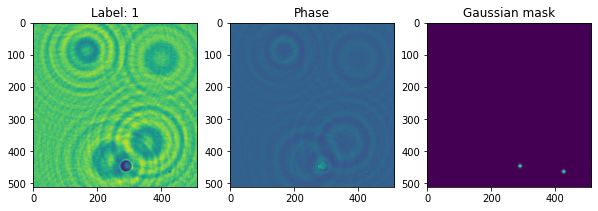

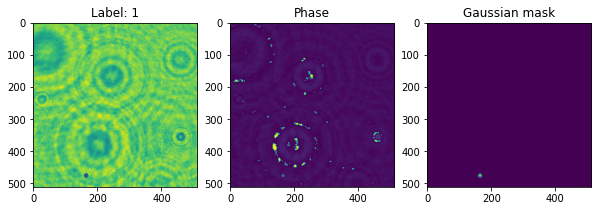

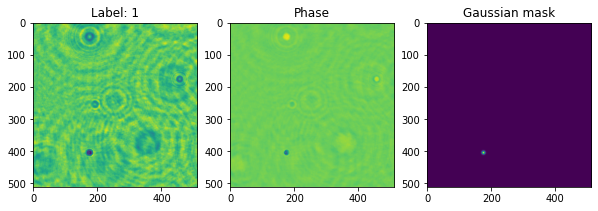

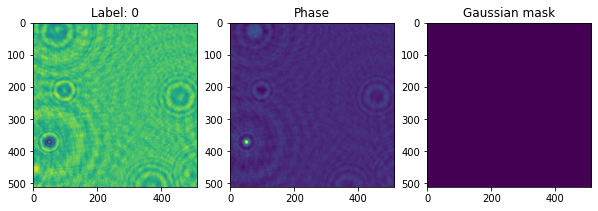

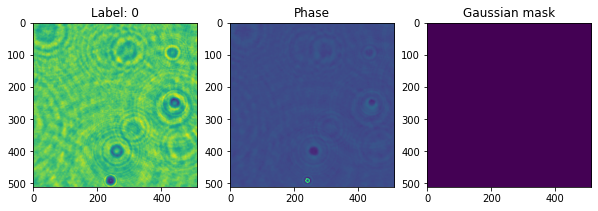

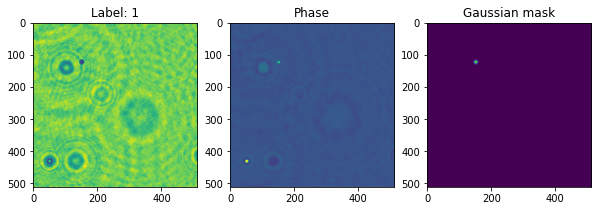

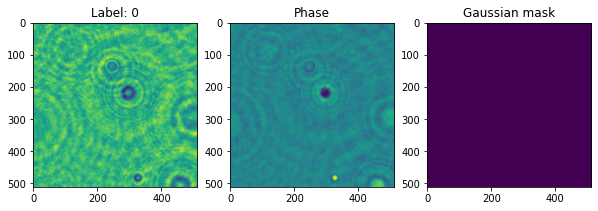

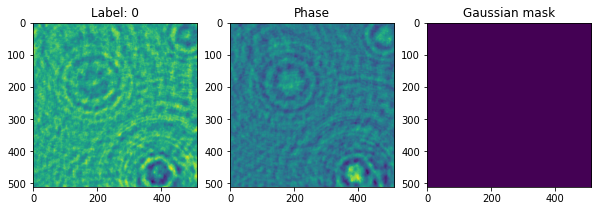

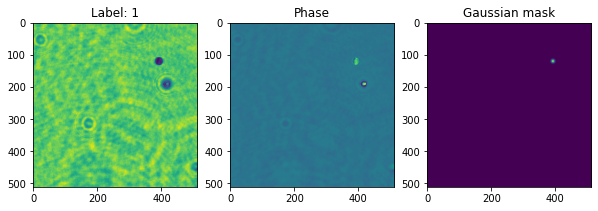

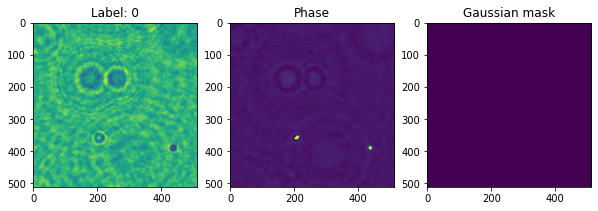

In [58]:
for data in tqdm.tqdm(holo_tiles, total = total_holograms):
    for idx in range(len(data[0])):
        fig,ax = plt.subplots(1,3,figsize=(10,5))
        ax[0].imshow(np.abs(data[1][idx]))
        ax[0].set_title(f"Label: {data[0][idx]}")
        ax[1].imshow(np.angle(data[1][idx]))
        ax[1].set_title(f"Phase")
        ax[2].imshow(np.abs(data[4][idx]))
        ax[2].set_title(f"Gaussian mask")
        
    break

In [ ]:
#with open("train_data.pkl", "wb") as fid:

total_pts = 50000

saved = 0 

fn = f'training_{tile_size}_{step_size}_{total_pts}.pkl'

#with h5py.File(fn, 'w') as hf:
with open(fn, "wb") as fid:
    for data in tqdm.tqdm(holo_tiles, total = total_holograms):
        for idx in range(len(data[0])):
            
#             fig,ax = plt.subplots(1,2,figsize=(10,5))
#             ax[0].imshow(np.abs(data[1][idx]))
#             ax[0].set_title(f"Label: {data[0][idx]}")
#             ax[1].imshow(np.abs(data[4][idx]))

            label = int(data[0][idx])
            image = np.expand_dims(np.abs(data[1][idx]), 0)
            phase = np.expand_dims(np.angle(data[1][idx]), 0)
            stacked_image = np.vstack([image, phase])

            image_tile_idx = data[2][idx]
            image_tile_coors = data[3][idx]
            u_net_mask = data[4][idx]
            
#             hf.create_dataset(f"label_{saved}",  data=label)
#             hf.create_dataset(f"image_{saved}",  data=stacked_image)
#             hf.create_dataset(f"tile_idx_{saved}",  data=image_tile_idx)
#             hf.create_dataset(f"tile_coors_{saved}",  data=image_tile_coors)
#             hf.create_dataset(f"u_net_mask_{saved}",  data=u_net_mask)
            
            saved += 1
        
            pickle.dump((stacked_image, label, u_net_mask, image_tile_idx, image_tile_coors), fid)

### Test loading the data from disk

In [3]:
# Load all of the data into memory
images = []
labels = []
masks = []

loaded = 0
max_images = 10

start_time = time.time()
with open(fn, "rb") as fid:
    while True:
        
        try:
            image, label, u_net_mask, image_tile_idx, image_tile_coors = pickle.load(fid)
            images.append(np.expand_dims(image, 0))
            labels.append(label)
            masks.append(np.expand_dims(u_net_mask, 0))
            
            loaded += 1
            
            if len(images) == max_images:
                break
            
        except Exception as E:
            break
            
images = np.vstack(images)
labels = np.vstack(labels)
masks = np.vstack(masks)

end_time = time.time()

In [4]:
print(f"It took {end_time - start_time} s to load {loaded} (x,y) points")

((10000, 2, 512, 512), (10000, 1))

In [5]:
print(images.shape, labels.shape, masks.shape)